# Metadata Explorer

__Description__: Opens the metadata file created by `PM-EventsTable.ipynb` or `distalEventsTable.ipynb` and explores the metadata associated with the excess rainfall calculation. 

__Input__: The metadata *.json file created by `PM-EventsTable.ipynb` or `distalEventsTable.ipynb`.

__Output__: User-specified metadata as a *.csv.

---



### Load Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*

### Specify the Filename and Path:

In [2]:
filename = 'Passaic_P03_D01_Metadata'
path = pl.Path(r"C:\Users\sputnam\Documents\Projects\PFRA\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P03_Metadata")

### Open the Metadata File and Extract Data:

---

In [3]:
with open(path/'{0}.json'.format(filename)) as f:
    metadata = json.load(f)

#### Extract the durations:

In [4]:
durations = list(metadata.keys())
print('Durations:', durations)

Durations: ['H06', 'H12', 'H24', 'H96']


#### Select a duration and extract the boundary condition names:

In [5]:
#dur = durations[0] 
dur = 'H24'

BCName = list(metadata[dur]['BCName'].keys())
print('Boundary condition names:', BCName)

Boundary condition names: ['D01']


#### Select a boundary condition name and extract the types of metadata available:

In [11]:
BCN = BCName[0]   
#BCN = 'D01'

scen = metadata[dur]['BCName'][BCN]
types = list(scen.keys())
print('Metadata types:', types)

Metadata types: ['groups', 'test_stat', 'precip', 'cum_excess', 'incr_excess', 'parameters', 'events_metadata']


#### Extract each type of metadata:

In [12]:
events_metadata = scen['events_metadata']
precip = scen['precip']
incr_excess = scen['incr_excess']
cum_excess = scen['cum_excess']
parameters = scen['parameters']
try: 
    test_stat = scen['test_stat']
except:
    print('No test statistics available')
groups = scen['groups']

### Explore Each Type of Metadata:
---
#### Events_metadata:
- The events_metadata dictionary contains the metadata associated with calculating the original excess rainfall events, including, but not limited to*, the following:
    - __TR__ : Recurrance Interval
    - __Rand Precipitation__ : The randomly selected precipitation amount
    - __Quartile__ : NOAA Atlas 14 temporal distribution quartile
    - __Decile__ : NOAA Atlas 14 decile for the specific quartile
    - __Random CN__ : The randomly selected curve number


- The 'keys' of the events_metadata dictionary are the metadata types, while the 'values' are the values for each metadata type.
- The events_metadata dictionary is transformed into a dataframe in order to explore the data more easily.
- *Contact sputnam@Dewberry.com for information about the metadata types not described above.

In [13]:
events_metadata_types = list(events_metadata.keys())
print('There are {0} types of metadata available, including {1}'.format(len(events_metadata_types), events_metadata_types))
events_metadata_df = pd.DataFrame.from_dict(events_metadata)
events_metadata_df = events_metadata_df.set_index('EventID')
events_metadata_df.head()

There are 24 types of metadata available, including ['Tr', 'Ann. Exc. Prob.', 'ARI', 'Log10_ARI', 'Expected Value', 'Lower (90%)', 'Upper (90%)', 'Quartile', 'Sigma', 'Fitted Lower (90%) Limit', 'Fitted Upper (90%) Limit', 'Random Precipitation', 'AMC I (Dry) CN', 'AMC II CN', 'AMC III (Wet) CN', 'alpha CN', 'beta CN', 'CN Lower Limit', 'Fitted AMC I (Dry) CN', 'Fitted AMC II CN', 'Fitted AMC III (Wet) CN', 'Random CN', 'Decile', 'EventID']


,Tr,Ann. Exc. Prob.,ARI,Log10_ARI,Expected Value,Lower (90%),Upper (90%),Quartile,Sigma,Fitted Lower (90%) Limit,...,AMC II CN,AMC III (Wet) CN,alpha CN,beta CN,CN Lower Limit,Fitted AMC I (Dry) CN,Fitted AMC II CN,Fitted AMC III (Wet) CN,Random CN,Decile
EventID,,,,,,,,,,,,,,,,,,,,,
E240001,2.001069,0.499733,1.443808,0.367284,3.319373,3.065327,3.622328,1,0.065746,3.051151,...,79.0,91.0,1.501671,2.033564,55.144962,62.000073,79.001628,90.998464,94,70
E240002,2.002854,0.499288,1.445665,0.368569,3.320302,3.066179,3.623335,1,0.065667,3.052316,...,79.0,91.0,1.501671,2.033564,55.144962,62.000073,79.001628,90.998464,63,60
E240003,2.005689,0.498582,1.448615,0.370608,3.321776,3.067530,3.624934,1,0.065746,3.053361,...,79.0,91.0,1.501671,2.033564,55.144962,62.000073,79.001628,90.998464,64,20
E240004,2.006019,0.498500,1.448958,0.370845,3.321948,3.067687,3.625119,1,0.065746,3.053519,...,79.0,91.0,1.501671,2.033564,55.144962,62.000073,79.001628,90.998464,96,10
E240005,2.008187,0.497962,1.451213,0.372400,3.323072,3.068718,3.626339,1,0.065746,3.054554,...,79.0,91.0,1.501671,2.033564,55.144962,62.000073,79.001628,90.998464,72,10


---
#### __Precip__:
- The precip dictionary contains the cumulative precipitation data for each of the original events.
- The 'keys' of the precip dictionary are the original event IDs, while the 'values' are dictionaries containing the index and cumulative precipitation for each event.
- The precip dictionary is transformed into a dataframe in order to explore the data more easily.

,E240001,E240002,E240003,E240004,E240005,E240006,E240007,E240008,E240009,E240010,...,E245031,E245032,E245033,E245034,E245035,E245036,E245037,E245038,E245039,E245040
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.434817,0.630460,1.456042,1.738788,1.935112,0.744283,0.370178,1.047375,1.064858,0.391865,...,1.523634,1.126439,0.876982,0.303824,0.556853,0.206986,1.540846,0.858687,0.250477,0.574838
4.0,1.000080,1.355127,2.473181,2.704431,3.009783,1.485153,0.925444,1.874581,1.905872,0.979664,...,2.479286,1.942442,1.645695,0.607647,1.102787,0.389620,2.657049,1.664532,0.471487,1.164804
6.0,1.515649,1.978341,3.020067,3.035779,3.378543,2.079214,1.477283,2.415568,2.455889,1.563833,...,3.101362,2.536704,2.284485,0.900218,1.583209,0.572255,3.469936,2.351482,0.692496,1.709387
8.0,1.835550,2.376908,3.288285,3.127294,3.480391,2.458184,1.820040,2.742676,2.788457,1.926672,...,3.615250,3.042271,2.825832,1.181536,2.009038,0.767065,4.161497,2.945958,0.928239,2.208589


None


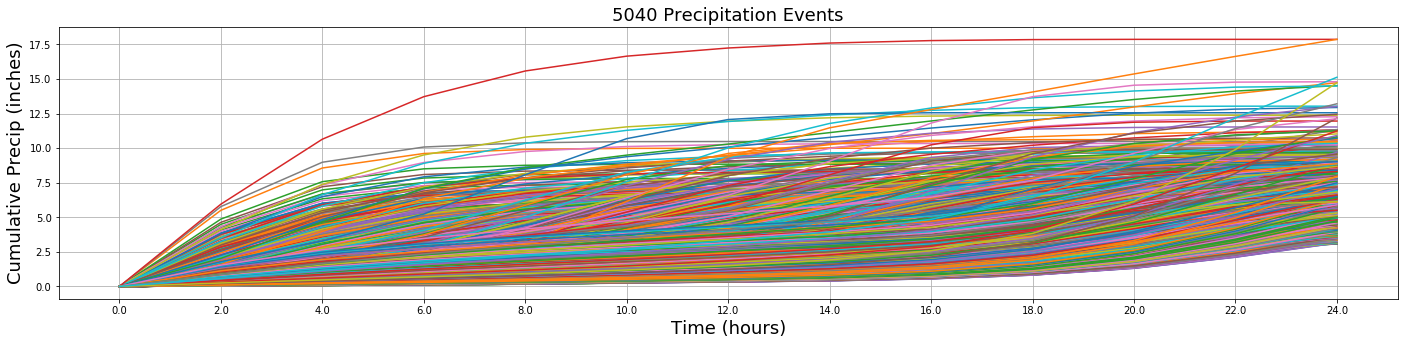

In [14]:
precip_df = pd.DataFrame.from_dict(precip)

print(display(precip_df.head()))

plot_cum_precip_or_excess(precip_df)

---
#### __Cum_excess__:
- The cum_excess dictionary contains the cumulative excess rainfall data for each of the original events.
- The 'keys' of the cum_excess dictionary are the original event IDs, while the 'values' are dictionaries containing the index and cumulative excess rainfall for each event.
- The cum_excess dictionary is transformed into a dataframe in order to explore the data more easily.

,E240001,E240002,E240003,E240004,E240005,E240006,E240007,E240008,E240009,E240010,...,E245031,E245032,E245033,E245034,E245035,E245036,E245037,E245038,E245039,E245040
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2.0,0.099789,0.000000,0.018400,1.322572,0.265431,0.000000,0.000000,0.083800,0.089087,0.000000,...,0.648507,0.028687,0.060409,0.000000,0.000000,0.0,0.056353,0.000000,0.000000,0.000000
4.0,0.503811,0.005383,0.260655,2.261582,0.813909,0.006459,0.088234,0.450738,0.468325,0.014617,...,1.436614,0.268413,0.393015,0.000000,0.032453,0.0,0.423731,0.069524,0.017880,0.000000
6.0,0.950760,0.096753,0.477560,2.587309,1.042271,0.089080,0.333391,0.781384,0.808016,0.150164,...,1.991697,0.547791,0.791990,0.006675,0.156637,0.0,0.833244,0.269673,0.082079,0.044632
8.0,1.243246,0.204307,0.600877,2.677461,1.108112,0.183708,0.533314,1.003983,1.036248,0.288367,...,2.463898,0.833352,1.181109,0.047144,0.324310,0.0,1.245361,0.519265,0.186533,0.154789


None


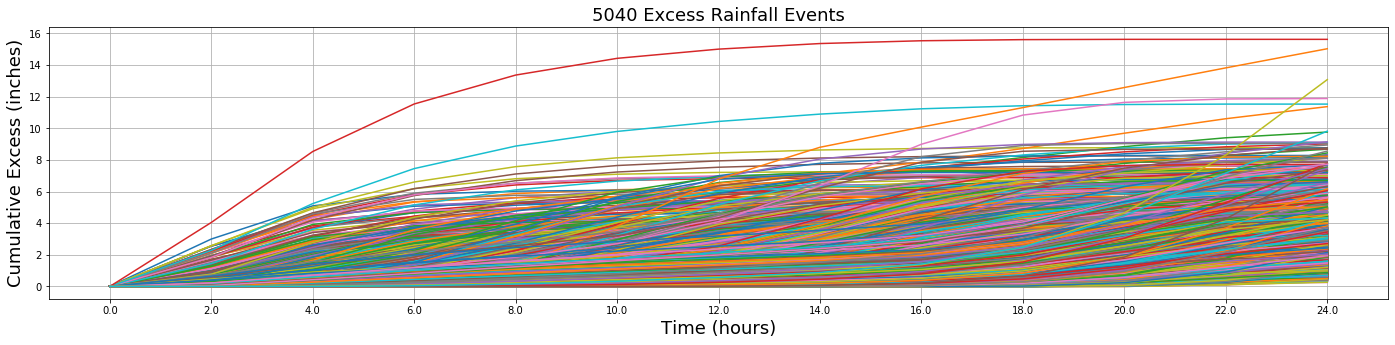

In [15]:
cum_excess_df = pd.DataFrame.from_dict(cum_excess)

print(display(cum_excess_df.head()))

plot_cum_precip_or_excess(cum_excess_df, 'Excess')

---
#### __Incr_excess__:
- The incr_excess dictionary contains the incremental excess rainfall data for each of the original events.
- The 'keys' of the incr_excess dictionary are the original event IDs, while the 'values' are dictionaries containing the index and incremental excess rainfall for each event.
- The incr_excess dictionary is transformed into a dataframe in order to explore the data more easily.

,E240001,E240002,E240003,E240004,E240005,E240006,E240007,E240008,E240009,E240010,...,E245031,E245032,E245033,E245034,E245035,E245036,E245037,E245038,E245039,E245040
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2.0,0.099789,0.002505,0.018400,1.322572,0.265431,0.003237,0.035294,0.083800,0.089087,0.005847,...,0.648507,0.028687,0.060409,0.002253,0.016387,5.646034e-08,0.056353,0.035865,0.009498,0.015009
4.0,0.404023,0.002879,0.242255,0.939009,0.548478,0.003222,0.052941,0.366938,0.379238,0.008770,...,0.788107,0.239726,0.332605,0.002253,0.016066,4.981794e-08,0.367377,0.033658,0.008381,0.015404
6.0,0.446949,0.091369,0.216905,0.325727,0.228363,0.082622,0.245157,0.330646,0.339692,0.135547,...,0.555083,0.279378,0.398975,0.002169,0.124184,4.981794e-08,0.409514,0.200150,0.064199,0.014219
8.0,0.292486,0.107554,0.123318,0.090152,0.065840,0.094628,0.199923,0.222600,0.228231,0.138203,...,0.472201,0.285561,0.389119,0.040469,0.167673,5.313914e-08,0.412116,0.249591,0.104454,0.110157


None


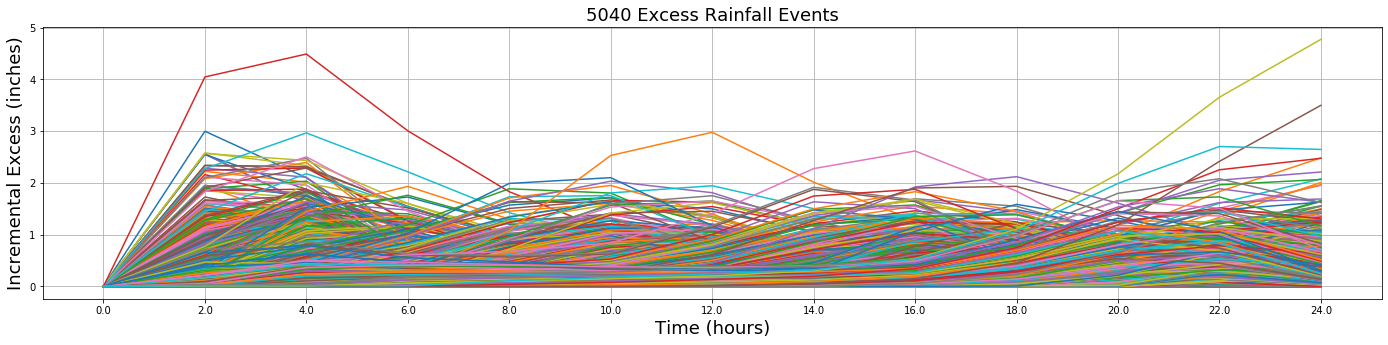

In [16]:
incr_excess_df = pd.DataFrame.from_dict(incr_excess)

print(display(incr_excess_df.head()))

plot_incr_excess(incr_excess_df)

---
#### Parameters:
- The parameters dictionary contains the random number generator seed and the convolution parameters used in grouping the individual excess rainfall events.

In [17]:
seed = parameters['seed']
tempEpsilon = parameters['tempEpsilon']
tempEpsilon2 = parameters['tempEpsilon2']
convEpsilon = parameters['convEpsilon']
volEpsilon = parameters['volEpsilon']

print('Seed: {0}\nConvolution parameters: tempEpsilon: {1} hours, tempEpsilon2: {2} hours, ' 
      'convEpsilon: {3}, volEpsilon: {4}'.format(seed, tempEpsilon, tempEpsilon2, convEpsilon, volEpsilon))

Seed: 2288
Convolution parameters: tempEpsilon: 4 hours, tempEpsilon2: 2 hours, convEpsilon: 160.0, volEpsilon: 66.67


---
#### __Groups__:
- The groups dictionary contains the IDs of the individual excess rainfall events that were grouped in order to form the final/mean events. 
- The 'keys' of the groups dictionary are the final event IDs, while the 'values' are the original event IDs.

In [18]:
final_events = list(groups.keys())
n_final_events = len(final_events)

print('There are {0} final/mean events for the {1} duration and the {2} boundary condition, including '.format(n_final_events, dur, BCN))
if n_final_events>20:
    print(final_events[:20],'...')
else:
    print(final_events)

There are 247 final/mean events for the H24 duration and the D01 boundary condition, including 
['E2001', 'E2002', 'E2003', 'E2004', 'E2005', 'E2006', 'E2007', 'E2008', 'E2009', 'E2010', 'E2011', 'E2012', 'E2013', 'E2014', 'E2015', 'E2016', 'E2017', 'E2018', 'E2019', 'E2020'] ...


##### Select a specific final event and extract the original event IDs:

In [23]:
selected_events = ['E2010', 'E2025', 'E2050', 'E2150', 'E2247']

In [47]:
df = pd.read_csv(r"C:\Users\sputnam\Documents\Projects\PFRA\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P03_D01_Events_TRI.csv")
all_events = list(df['Events'])
selected_events = [event for event in all_events if 'E2' in event]
print(len(all_events), len(selected_events))
df.head(2)

65 15


,Events
0,E0001
1,E3054


In [48]:
for final_event in selected_events:
    original_events = list(groups[final_event])
    temp_df = events_metadata_df.loc[original_events].copy()
    print(final_event)
    print('Number of Events:', temp_df.shape[0])
    print('Return Interval Range:', temp_df['Tr'].min(), temp_df['Tr'].max(), temp_df['Tr'].mean())
    print('Precipitation Range:', temp_df['Random Precipitation'].min(), temp_df['Random Precipitation'].max(), temp_df['Random Precipitation'].mean())
    print('Curve Number Range:', temp_df['Random CN'].min(), temp_df['Random CN'].max(), temp_df['Random CN'].mean(), '\n')

E2102
Number of Events: 14
Return Interval Range: 13.867886678464027 111.36170719201948 39.27024609558656
Precipitation Range: 5.382136584941337 8.746477576632028 6.635647908212599
Curve Number Range: 71 97 87.35714285714286 

E2211
Number of Events: 2
Return Interval Range: 33.7817557117001 60.09747900898656 46.939617360343334
Precipitation Range: 6.361968976790418 7.784592913956589 7.0732809453735035
Curve Number Range: 80 91 85.5 

E2182
Number of Events: 3
Return Interval Range: 37.2521360931523 212.3886813088942 135.80381599984642
Precipitation Range: 7.033110985281883 10.481280844311136 9.169719055320039
Curve Number Range: 64 92 74.0 

E2130
Number of Events: 8
Return Interval Range: 14.114130505455027 322.5965703218674 91.77208450521535
Precipitation Range: 5.934062751742117 10.742270349320384 7.840037285307117
Curve Number Range: 67 97 85.625 

E2126
Number of Events: 9
Return Interval Range: 33.7817557117001 157.44038231365033 73.0716171688258
Precipitation Range: 6.756828952

---
#### __Test_stat__:
- The test_stat dictionary contains the final value of the test statistic for each individual excess rainfall event and its corresponding final/mean event. This test statistic is a quantatiative measure of the similarity between the original excess rainfall curve and the final/mean excess rainfall curve. See the `Convolution_Parameters.ipynb` for additional details about interpreting the test statistic values. 
- The 'keys' of the test_stat dictionary are the final event IDs, while the 'values' are the test statistics for the individual excess rainfall events that were grouped in order to form the final/mean event.
- The test statistics for the final event specified above are shown below. 

In [ ]:
if 'test_stat' in locals(): 
    event_test_stats = list(test_stat[final_event])
    max_test_stat = max(event_test_stats)
    min_test_stat = min(event_test_stats)

    print('For final event: {0} the maximum test statistic is {1}, while the minimum is {2}.'.format(final_event, max_test_stat, min_test_stat))   

---
### Save select data to csv:

#### From a dataframe (events_metadata_df, precip_df, incr_excess_df, cum_excess_df):
- Specify the type of metadata to be saved (the type of metadata will be appended to the original metadata filename when saved as a .csv).
- Specify the corresponding dataframe to save by typing the dataframe name in front of '.to_csv'. 
- Execute the cell (shift+enter).

In [ ]:
metadata_type = 'Events_Metadata'

events_metadata_df.to_csv(path/'{0}_{1}.csv'.format(filename, metadata_type))

#### From a dictionary (parameters, groups, test_stat):
- Specify the type of metadata to be saved (the type of metadata will be appended to the original metadata filename when saved as a .csv).
- Specify the corresponding dataframe to save by typing the dataframe name in the function 'dict_to_df.
- Execute the cell (shift+enter).

In [ ]:
metadata_type = 'groups'

df = dict_to_df(groups, display_head=True)

df.to_csv(path/'{0}_{1}.csv'.format(filename, metadata_type))        

---
# End